In [1]:
import argparse
import os
import time
import pytorch_lightning as pl
import torchvision.transforms
from rich import print
from torch.utils.data import DataLoader
import lima
import glob
import h5py
import skimage.io as io
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np
import cmcrameri.cm as cmc
from pykitPIV import Particle, FlowField, Motion, Image

<a id=synthetic-images></a>

***

## Generate synthetic images with `pykitPIV`

[Go to the top](#top-page)

In [2]:
image_size = (256,256)
size_buffer = 10
figsize = (5,3)

In [3]:
def generate_images(n_images, random_seed):

    tic = time.perf_counter()

    # Instantiate an object of the Particle class:
    particles = Particle(n_images,
                         size=image_size,
                         size_buffer=size_buffer,
                         diameters=(4,4.1),
                         distances=(1,2),
                         densities=(0.05,0.1),
                         signal_to_noise=(5,20),
                         diameter_std=0.2,
                         seeding_mode='random',
                         random_seed=random_seed)

    # Instantiate an object of the FlowField class:
    flowfield = FlowField(n_images,
                          size=image_size,
                          size_buffer=size_buffer,
                          random_seed=random_seed)

    flowfield.generate_random_velocity_field(gaussian_filters=(10,11),
                                             n_gaussian_filter_iter=20,
                                             displacement=(0,10))

    # Instantiate an object of the Motion class:
    motion = Motion(particles, 
                    flowfield, 
                    time_separation=0.1)

    # Advect particles:
    motion.forward_euler(n_steps=10)

    # Instantiate an object of the Image class:
    image = Image(random_seed=random_seed)

    # Prepare images - - - - - - - - - - - - - - - - - - 

    image.add_particles(particles)

    image.add_flowfield(flowfield)
  
    image.add_motion(motion)
    
    image.add_reflected_light(exposures=(0.7,0.8),
                              maximum_intensity=2**16-1,
                              laser_beam_thickness=1,
                              laser_over_exposure=1,
                              laser_beam_shape=0.95,
                              alpha=1/10)

    image.remove_buffers()

    toc = time.perf_counter()

    print(f'Time it took: {(toc - tic)/60:0.1f} minutes.\n')

    return image

<a id=synthetic-images-training-set></a>

### Training set

[Go to the top](#top-page)

In [4]:
n_images = 2

In [5]:
training_random_seed = 100

In [6]:
image_train = generate_images(n_images, training_random_seed)

image_pairs_train = image_train.image_pairs_to_tensor()
targets_train = image_train.targets_to_tensor()

Particles added to the image.
Velocity field added to the image.
Particle movement added to the image.
Reflected light added to images I1.
Reflected light added to images I2.
Buffers removed from images I1.
Buffers removed from images I2.
Buffers removed from the velocity field.


Time it took: 0.0 minutes.

In [7]:
# image_train.save_to_h5({'I': image_pairs_train, 'targets': targets_train}, filename='PIV-dataset-train.h5')

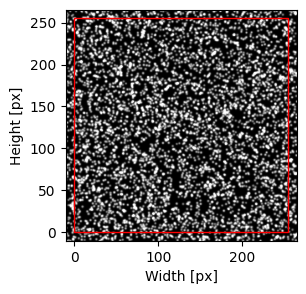

In [8]:
image_train.plot(0,
                 instance=1,
                 with_buffer=True,
                 xlabel='Width [px]',
                 ylabel='Height [px]',
                 cmap='Greys_r',
                 figsize=figsize);

In [9]:
max_of_images = np.max(image_pairs_train)
max_of_images

65535.0

In [10]:
num_chs = [1, 16, 32, 64, 96, 128, 196]

In [11]:
fe = lima.lima.FeatureExtractor(num_chs)

In [12]:
x_init = torch.from_numpy(image_pairs_train[0:1,0:1,:,:].astype(np.float32))

In [13]:
init_features = fe.forward(x_init)

In [14]:
for i in range(0,len(num_chs)-1):
    print(init_features[i].shape)

torch.Size([1, 196, 4, 4])

torch.Size([1, 128, 8, 8])

torch.Size([1, 96, 16, 16])

torch.Size([1, 64, 32, 32])

torch.Size([1, 32, 64, 64])

torch.Size([1, 16, 128, 128])

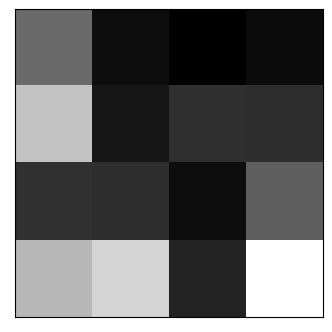

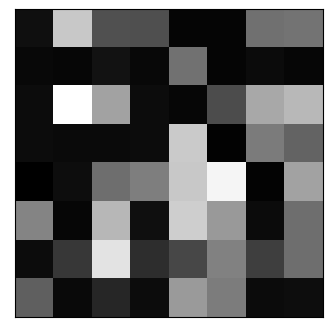

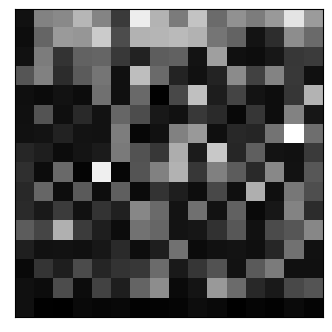

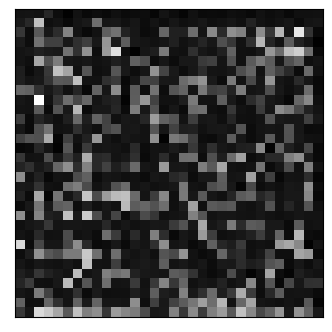

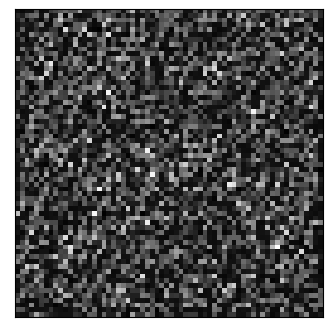

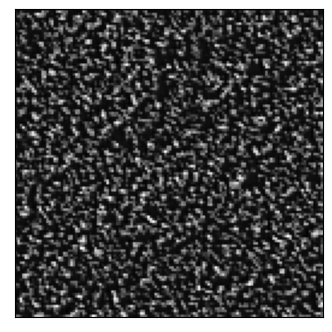

In [15]:
for i in range(0,len(num_chs)-1):
    
    fig = plt.figure(figsize=(4,4))
    plt.imshow(init_features[i][0,10,:,:].detach(), cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])
    plt.savefig('Feature-' + str(i) + '.png', dpi=300, bbox_inches='tight')

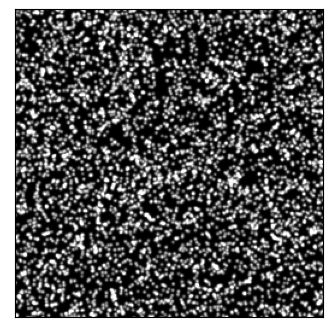

In [16]:
fig = plt.figure(figsize=(4,4))
plt.imshow(x_init[0,0,:,:], cmap='Greys_r')
plt.xticks([])
plt.yticks([])
plt.savefig('Original-image.png', dpi=300, bbox_inches='tight')

***